In [180]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional,Literal
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_community.utilities import GoogleSerperAPIWrapper
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv

In [181]:
load_dotenv(override=True)

True

In [182]:

class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

In [183]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]  # List of messages in the state
    success_criteria: str                            # Description of success criteria
    feedback_on_work: Optional[str]                  # Optional feedback from evaluator
    success_criteria_met: bool                       # True if success criteria is met
    user_input_needed: bool                           # True if user input/clarification is required

In [184]:
# Get our async Playwright tools
import nest_asyncio
nest_asyncio.apply()
async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [188]:
worker_llm=ChatOpenAI(model="gpt-4o-mini")
worker_llm_with_tools=worker_llm.bind_tools(tools)

evaluator_llm=ChatOpenAI(model="gpt-4o-mini")
evaluator_llm_with_sturctured_output=evaluator_llm.with_structured_output(EvaluatorOutput)

In [189]:

def worker(state: State) -> Dict[str, Any]:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
This is the success criteria:
{state['success_criteria']}
You should reply either with a question for the user about this assignment, or with your final response.
If you have a question for the user, you need to reply by clearly stating your question. An example might be:

Question: please clarify whether you want a summary or a detailed answer

If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
Here is the feedback on why this was rejected:
{state['feedback_on_work']}
With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    # Add in the system message

    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = worker_llm_with_tools.invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
    }


In [190]:
def worker_router(state:State) ->str:
    last_message=state['messages'][-1]
    if hasattr(last_message,'tool_calls') and last_message.tool_calls:
        return 'tools'
    else:
        'evaluator'

In [191]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [192]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
and whether more input is needed from the user."""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

The entire conversation with the assistant, with the user's original request and all replies, is:
{format_conversation(state['messages'])}

The success criteria for this assignment is:
{state['success_criteria']}

And the final response from the Assistant that you are evaluating is:
{last_response}

Respond with your feedback, and decide if the success criteria is met by this response.
Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
"""
    if state["feedback_on_work"]:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_sturctured_output.invoke(evaluator_messages)
    new_state = {
        "messages": [{"role": "assistant", "content": f"Evaluator Feedback on this answer: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state


In [193]:
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

In [194]:
#build graph
graph_builder=StateGraph(State)

#add node
graph_builder.add_node('worker',worker)
graph_builder.add_node('evaluator',evaluator)
graph_builder.add_node('tools',ToolNode(tools=tools))

#add edges

graph_builder.add_conditional_edges('worker',worker_router,{"tools":"tools","evaluator":"evaluator"})
graph_builder.add_edge('tools','worker')
graph_builder.add_conditional_edges('evaluator',route_based_on_evaluation,{"worker":"worker","END":END})
graph_builder.add_edge(START,"worker")



In [195]:
#compile the graph
memory=MemorySaver()
workflow=graph_builder.compile(checkpointer=memory)


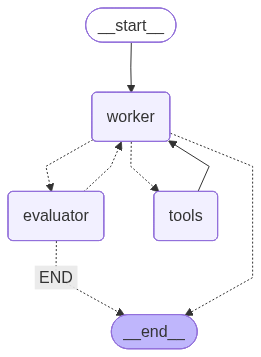

In [196]:
#display workflow
display(Image(workflow.get_graph().draw_mermaid_png()))

In [197]:
def make_thread_id() -> str:
    return str(uuid.uuid4())


async def process_message(message, success_criteria, history, thread):

    config = {"configurable": {"thread_id": thread}}

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await workflow.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()


In [198]:

with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

    
demo.launch()

* Running on local URL:  http://127.0.0.1:7872
* To create a public link, set `share=True` in `launch()`.
